# Introdução

Nas três lições anteriores, você aprendeu vários conceitos fundamentais de série temporal, como estacionariedade e suavização. Agora vamos desenvolver esse conhecimento investigando outro conceito importante chamado ** autocorrelação **.

# Resultados de Aprendizagem
Você deve sair deste tutorial com:
1. Uma compreensão prática dos modelos de média móvel (MA).
2. Uma compreensão básica da Função de Autocorrelação (ACF).
3. Visão geral sobre como escolher a ordem * q * dos modelos MA.
4. Uma compreensão prática dos modelos Autorregressivos (AR).
5. Uma compreensão básica da Função de Autocorrelação Parcial (PACF).
6. Visão geral sobre como escolher a ordem * p * dos modelos AR.

# Importações

In [24]:
%matplotlib inline

import sys
import statsmodels as ss
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

# Python & Library Versions

In [25]:
versions = ( ("matplotlib", matplotlib.__version__),
            ("numpy", np.__version__),
            ("pandas", pd.__version__),
            ("statsmodels", ss.__version__) )

print(sys.version, "\n")
print("library" + " " * 4 + "version")
print("-" * 18)

for tup1, tup2 in versions:
    print("{:11} {}".format(tup1, tup2))

3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0] 

library    version
------------------
matplotlib  3.2.2
numpy       1.19.5
pandas      1.1.5
statsmodels 0.10.2


---

# Section 1: Moving Average (MA) & MA Models 

In this lesson, we will revisit moving average smoothing and explore the idea of moving average models. Please be aware that these two concepts are not equivalent. Each serves a different, important function.

### O que é uma média móvel?
A média móvel é talvez uma das técnicas mais óbvias e simples que você pode usar para capturar mudanças locais nos dados de série temporal, bem como fornecer previsões. Na verdade, exploramos o MA com alguns detalhes na última lição. Discutimos a suavização simples e exponencial. Também discutimos a suavização exponencial simples, dupla e tripla. Se você estiver confuso sobre qualquer um desses termos, volte e revise agora.

Vamos desenvolver esse conhecimento indo um pouco mais fundo.

Lembre-se de que o valor da previsão $\hat{y}_{t+1} = \frac{y_t + y_{t-1} + ... + y_{t-m+1}}{m}$

Vale a pena ponderar essa fórmula por um minuto. Embora seja fácil de entender, uma de suas propriedades pode não ser óbvia. Qual é o atraso associado a esta técnica? Pensar sobre isso.

A resposta é $\frac{(m+1)}{2}$. Por exemplo, digamos que você esteja calculando a média dos últimos 5 valores para fazer a próxima previsão. Então, as mudanças locais produzirão uma defasagem de $\frac{5+1}{2} = 3$ $ períodos. Claramente, o atraso aumenta à medida que você aumenta o tamanho da janela para fazer a média.

Você pode pensar consigo mesmo: "Bem, usarei apenas um tamanho de janela pequeno." Isso criará um modelo mais responsivo. No entanto, um tamanho de janela muito pequeno perseguirá o ruído nos dados em vez de extrair o padrão. Como acontece com a maioria das coisas no aprendizado de máquina, há uma compensação entre os dois. A melhor resposta está em algum lugar e requer um ajuste cuidadoso para determinar qual configuração é a melhor para um determinado conjunto de dados.

Vamos gerar alguns dados de brinquedo e aplicar uma média móvel com tamanhos de janela diferentes para ver se o que discutimos é de fato verdade.

In [26]:
# reproducibility
np.random.seed(42)

# time component
time = np.arange(100)

# data
noise = np.random.normal(loc=0, scale=6.5, size=len(time))
trend = time * 2.75
seasonality = 10 + np.sin(time * 0.25) * 20
data = trend + seasonality + noise

Mais um lembrete amigável de que você deve sempre inspecionar visualmente sua série temporal com um gráfico de sequência de execução.
> Usaremos a função * run_sequence_plot * para tornar a plotagem em todo este tutorial menos complicada.

In [27]:
def run_sequence_plot(x, y, title, xlabel="time", ylabel="series"):
    plt.plot(x, y, 'k-', label="actual")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.3)
    plt.legend();

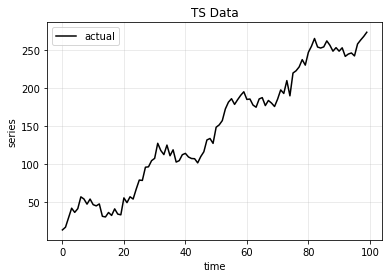

In [28]:
run_sequence_plot(time, data, title="TS Data")

Ótimo, agora precisamos de uma função de média móvel. Felizmente, o pandas tem uma função de [média contínua] (https://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.rolling_mean.html) que podemos aproveitar.

Tentaremos três tamanhos de janela: 3, 5, 9. Em seguida, plotaremos os resultados.

In [29]:
series = pd.Series(data)

# case with lag of 2
lag_2 = series.rolling(window=3).mean()

# case with lag of 3
lag_3 = series.rolling(window=5).mean()

# case with lag of 5
lag_5 = series.rolling(window=9).mean()

# case with lag of 10
lag_10 = series.rolling(window=19).mean()

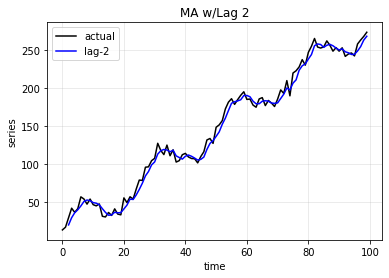

In [30]:
run_sequence_plot(time, data, title="MA w/Lag 2")
plt.plot(time, lag_2, 'b-', label="lag-2")
plt.legend();

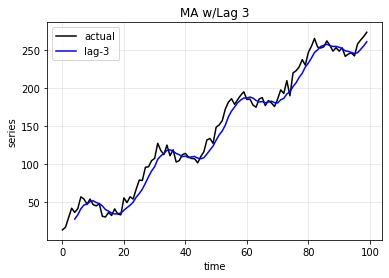

In [31]:
run_sequence_plot(time, data, title="MA w/Lag 3")
plt.plot(time, lag_3, 'b-', label="lag-3")
plt.legend();

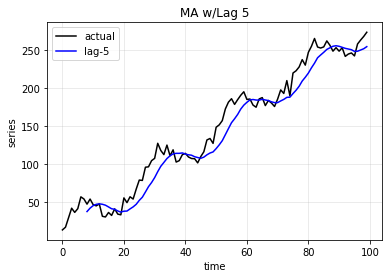

In [32]:
run_sequence_plot(time, data, title="MA w/Lag 5")
plt.plot(time, lag_5, 'b-', label="lag-5")
plt.legend();

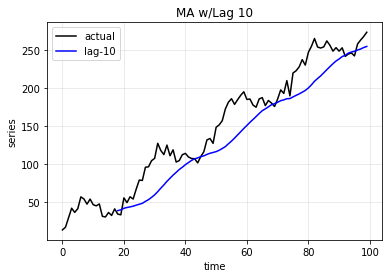

In [33]:
run_sequence_plot(time, data, title="MA w/Lag 10")
plt.plot(time, lag_10, 'b-', label="lag-10")
plt.legend();

A compensação é capacidade de resposta versus recursos de suavização. Vamos deixar isso mais claro plotando as três curvas de média móvel sem os dados reais.

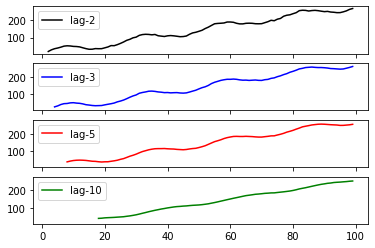

In [34]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=True)
axes[0].plot(time, lag_2, 'k-', label="lag-2")
axes[0].legend()
axes[1].plot(time, lag_3, 'b-', label="lag-3")
axes[1].legend()
axes[2].plot(time, lag_5, 'r-', label="lag-5")
axes[2].legend()
axes[3].plot(time, lag_10, 'g-', label="lag-10")
axes[3].legend();

### Modelos MA! = Suavização da média móvel
Uma distinção importante é que um modelo de média móvel não é a mesma coisa que suavização de média móvel. O que fizemos acima foi suavizar. Possui propriedades importantes já discutidas. No entanto, voltamos nossa atenção para os modelos de média móvel, que são uma fera completamente diferente.

A suavização da média móvel é útil para estimar a tendência e a sazonalidade de dados anteriores. Os modelos MA, por outro lado, são um modelo de previsão útil que regrede em erros de previsão do passado para prever valores futuros. É fácil juntar as duas técnicas, mas elas têm funções muito diferentes.

### Especificações do modelo MA
Um modelo MA é definido por esta equação: $ y_t = c + e_t + θ_1e_ {t − 1} + θ_2e_ {t − 2} + ⋯ + θ_qe_ {t − q} $ onde $ e_t $ é ruído branco. O valor $ c $ é um valor constante e os $ \ theta $ são coeficientes, não diferentes daqueles encontrados na regressão linear.

Ajustar um modelo MA é bastante complicado e requer procedimentos iterativos. Os detalhes estão além do escopo desta lição. No entanto, os modelos de estatísticas têm essa funcionalidade incorporada para que possamos construir um modelo com o mínimo de esforço. Vamos dar uma olhada.

### Modelos MA com Statsmodels

In [35]:
from statsmodels.tsa.arima_model import ARMA

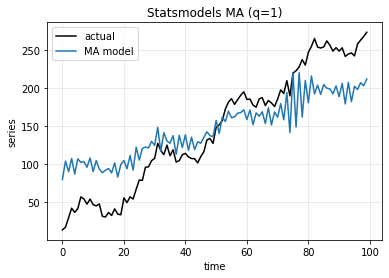

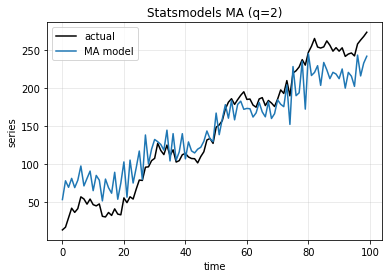

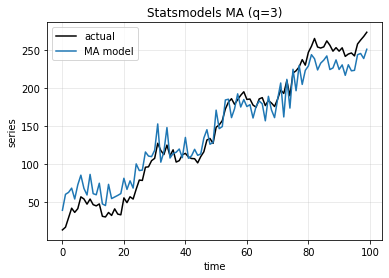

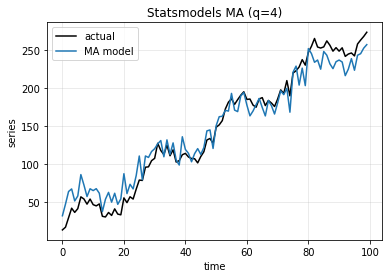

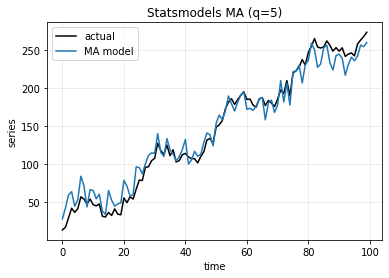

In [36]:
# plot different orders (q's)
for i in range(1,6):
    model = ARMA(data, (0,i)).fit()
    run_sequence_plot(time, data, title="Statsmodels MA (q={})".format(i))
    plt.plot(time, model.predict(start=1, end=100), label="MA model")
    plt.legend()
    plt.show();

Now that we understand the basics of MA models, let's turn our attention to selecting the proper order called *q*.

---

# Seção 2: A função de autocorrelação (ACF)
Há uma pergunta crucial que precisamos responder: como você escolhe a ordem, conhecida como * q *, do modelo MA?

Para responder a essa pergunta, precisamos entender a Função de Autocorrelação (ACF).

Vamos começar mostrando um exemplo de gráfico ACF para nosso conjunto de dados chamado * dados *.

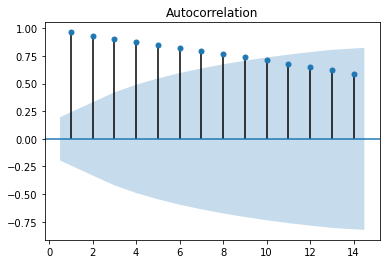

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

fig = plot_acf(data, lags=range(1,15), alpha=0.05)

Uma explicação está em ordem. Primeiro, a região azul representa um intervalo de confiança. O alfa, neste caso, foi definido como 0,05 (intervalo de confiança de 95%). Isso pode ser definido para qualquer valor flutuante que você precisar. Consulte a função ** plot_acf ** para obter detalhes.

As hastes representam valores de correlação defasados. Em outras palavras, uma defasagem de 1 se correlaciona quase perfeitamente com o valor endógeno atual. Um atraso de 2 se correlaciona quase, mas não tão bem. E assim por diante. Lembre-se de que estamos regredindo com base em erros de previsão anteriores; essa é a correlação que estamos inspecionando aqui.

Correlações fora do intervalo de confiança são estatisticamente significativas, enquanto as outras não. Você pode usar este gráfico para escolher o valor de * q * para incluir em seu modelo MA. Uma coisa importante a observar é que ** modelos MA requerem estacionariedade **. Você deve ver as correlações cair rapidamente. Caso contrário, é um sinal de que seus dados podem não estar estáticos, como vemos aqui.

No interesse do rigor, vamos testar nossos dados com o teste Augmented Dickey-Fuller, embora saibamos como esses dados específicos foram gerados (ou seja, eles têm tendência e sazonalidade). Portanto, não é estacionário. Podemos, entretanto, transformá-lo aplicando uma diferença e verificando a estacionariedade mais uma vez.

In [ ]:
from statsmodels.tsa.stattools import adfuller

adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(data)
print(pvalue)

0.9562340501068851


A p-value that high means we must fail to reject the null that this data is nonstationary - as we knew all along. Now let's apply three differences and check again.

In [ ]:
difference = data[:-1] - data[1:]
difference2 = difference[:-1] - difference[1:]

adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(difference2)
print(pvalue)

0.002099608424396523


We're stationary now!

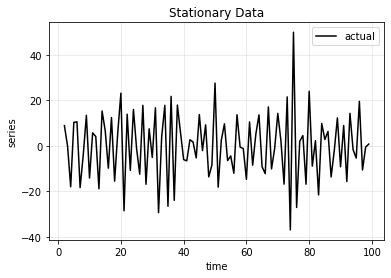

In [ ]:
run_sequence_plot(time[2:], difference2, title="Stationary Data")

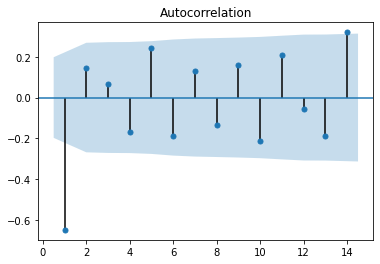

In [ ]:
fig = plot_acf(difference2, lags=range(1,15), alpha=0.05)

O gráfico acima mostra que AR (1) é o mais apropriado.
> Veja [aqui] (https://people.duke.edu/~rnau/411arim2.htm) para uma explicação detalhada.

Isso conclui nossa discussão sobre os modelos MA. Vamos agora voltar nossa atenção para os modelos de RA.

---

# Seção 3: Modelos Autorregressivos (AR)
Nesta lição, exploraremos a ideia de modelos autorregressivos e como determinar a ordem adequada com a Função de Autocorrelação Parcial (PACF).

### O que é um modelo autorregressivo?
Os modelos AR são semelhantes aos modelos MA com uma distinção fundamental. Os modelos MA regredem com base em erros de previsão anteriores para prever valores futuros. Por outro lado, os modelos de AR regredem em valores passados reais, não em erros passados.

Este é o primeiro pedido ou fórmula ** AR (1) ** que você deve saber: $ y_t = \ beta_0 + \ beta_1y_ {t-1} + \ epsilon_t $

Os $ \ beta $ são iguais aos da regressão linear e $ \ epsilon $ é um erro irredutível.

Um segundo pedido ou ** AR (2) ** ficaria assim: $ y_t = \ beta_0 + \ beta_1y_ {t-1} + \ beta_2y_ {t-2} + \ epsilon_t $

O padrão de adicionar outro coeficiente e outro termo anterior continua na ordem que você escolher. A escolha dessa ordem chamada * p * é algo que discutiremos em breve.

Enquanto isso, vamos examinar um exemplo básico de autocorrelação. Geraremos nossos próprios dados para que conheçamos o processo gerador.

In [ ]:
# seed to start series
seed = 14

# reproducibility
np.random.seed(123)

# create autocorrelated data
lagged = np.empty_like(time, dtype='float')
for t in time:
    lagged[t] = seed + np.random.normal(loc=0, scale=2.5, size=1)
    seed = lagged[t]
    if t > 0:
        lagged[t] = lagged[t] + (0.7 * lagged[t-1])

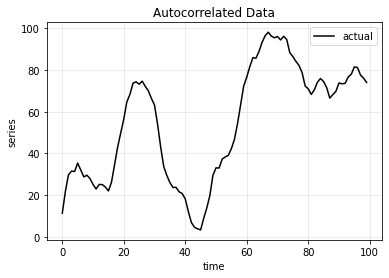

In [ ]:
run_sequence_plot(time, lagged, title="Autocorrelated Data");

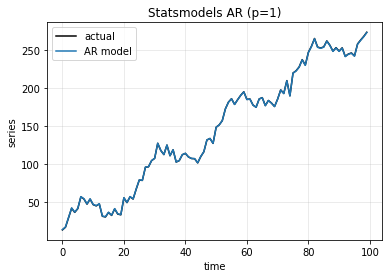

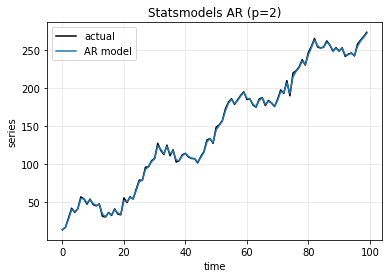

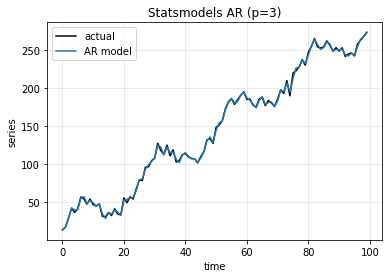

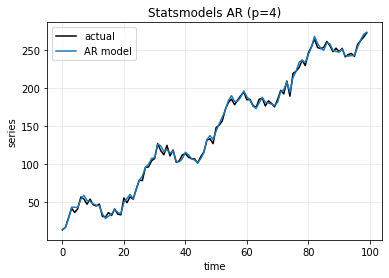

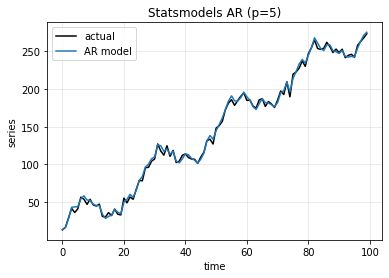

In [ ]:
# plot different orders (q's)
for i in range(1,6):
    model = ARMA(data, (i,0)).fit()
    run_sequence_plot(time, data, title="Statsmodels AR (p={})".format(i))
    plt.plot(time, model.predict(start=1, end=100), label="AR model")
    plt.legend()
    plt.show();

---

# Seção 4: A função de autocorrelação parcial (PACF)


Escolher a ordem *p* do modelo AR é importante. Felizmente, há um gráfico útil chamado gráfico de função de autocorrelação parcial que pode nos ajudar nessa tarefa.

Vejamos um exemplo.

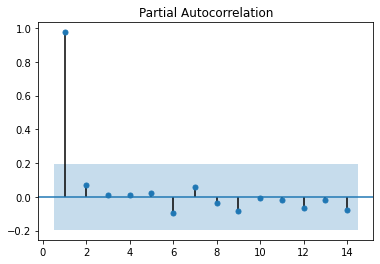

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

fig = plot_pacf(data, lags=range(1,15), alpha=0.05)

Este enredo é bastante fácil de ler. Em primeiro lugar, a região azul mais uma vez é o intervalo de confiança de 95%. O ACF é uma forma de medir a relação linear entre uma observação atual e as observações em períodos anteriores. Acontece que estamos realmente interessados apenas na relação entre a observação atual e um valor passado determinado por um valor de atraso. Muitas vezes não nos importamos com a relação de valores entre os dois, então os transformamos para obter o PACF. A principal lição é que o PACF é uma ferramenta útil para identificar a ordem do modelo AR.

Este exemplo mostra que um modelo AR (1) é mais apropriado para esses dados. Sabemos disso porque a autocorrelação parcial é significativa para essa defasagem, mas não para outras defasagens.

---


#Exercício # 4
Você recebeu dois conjuntos de dados:
1. ** auto_1.npy **
2. ** auto_2.npy **

Sua tarefa é aproveitar o que você aprendeu neste curso e nos anteriores.

Mais especificamente, você fará o seguinte:
1. Leia em ** auto_1.npy ** e ** auto_2.npy **.
2. Crie uma variável de tempo chamada ** mytime ** que começa em 0 e é tão longa quanto os dois conjuntos de dados.
3. Gere gráficos de sequência de execução de auto_1 e auto_2.
4. Determine a ordem de pe q.

#### 1. Get Data

In [37]:
# get data
auto_1 = np.load("auto_1.npy")
auto_2 = np.load("auto_2.npy")

#### 2. Create mytime 

In [38]:
# time component
mytime = np.arange(len(auto_1))

#### 3. Run-Sequence Plots

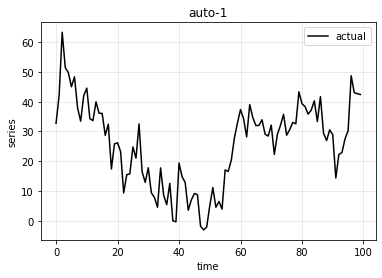

In [39]:
run_sequence_plot(mytime, auto_1, title="auto-1")

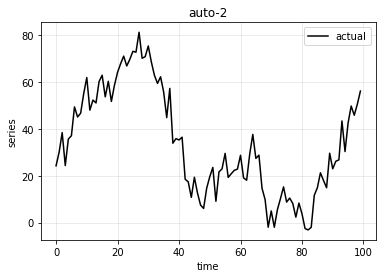

In [40]:
run_sequence_plot(mytime, auto_2, title="auto-2")

#### 4. Determine Order (p & q) 

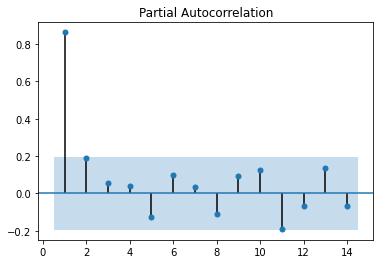

In [41]:
from statsmodels.graphics.tsaplots import plot_pacf

fig1 = plot_pacf(auto_1, lags=range(1,15), alpha=0.05)

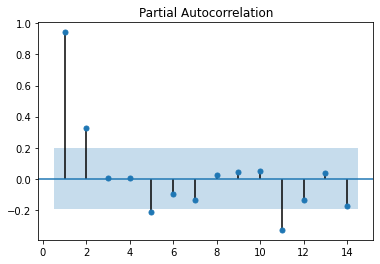

In [42]:
fig2 = plot_pacf(auto_2, lags=range(1,15), alpha=0.05)

For auto_1, order p is clearly 1.

For auto_2, order p is clearly 2. 

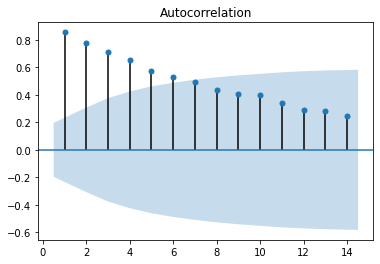

In [43]:
from statsmodels.graphics.tsaplots import plot_acf

fig3 = plot_acf(auto_1, lags=range(1,15), alpha=0.05)

Let's see if we can do better by differencing the data.

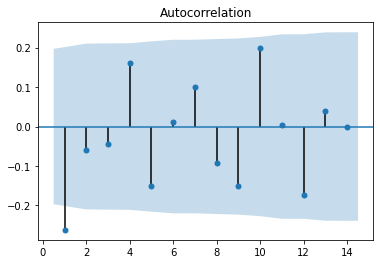

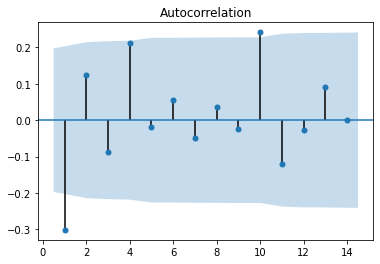

In [44]:
difference1 = auto_1[:-1] - auto_1[1:]
difference2 = auto_2[:-1] - auto_2[1:]

fig4 = plot_acf(difference1, lags=range(1,15), alpha=0.05)
fig5 = plot_acf(difference2, lags=range(1,15), alpha=0.05)

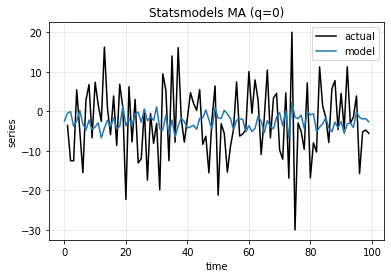

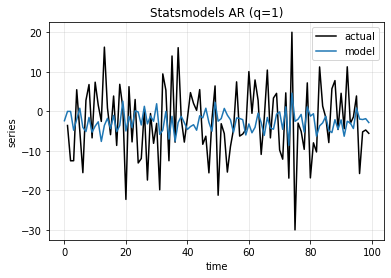

In [45]:
# plot different orders (q's)
for i in range(2):
    for j in range(2):
        if i == j:
            pass
        else:
            model = ARMA(difference, (i,j)).fit()
            if j == 1:
                run_sequence_plot(mytime[1:], 
                                  difference, 
                                  title="Statsmodels MA (q={})".format(i))
            else:
                run_sequence_plot(mytime[1:], 
                                  difference, 
                                  title="Statsmodels AR (q={})".format(i))
            plt.plot(time, model.predict(start=1, end=100), label="model")
            plt.legend()
            plt.show();

For auto_1, order q is 1.

For auto_2, order q is 1. 

---